In [1]:
import torch
import json
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import gensim #For word2vec
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import time
import nltk
import random
from numpy.random import choice as randomchoice
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import sys
# import torchtext
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import matplotlib as mlt

In [2]:
import gensim.downloader as api
import torchtext.vocab as vocab
glove_model = api.load("glove-wiki-gigaword-200")

In [16]:

train_start_time = time.time();
# val_file = sys.argv[2];
train_file = 'data/train.json'
val_file = 'data/dev.json'
test_file = 'data/test.json'

tokenize_func = nltk.tokenize.WordPunctTokenizer().tokenize
punctuations = '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~'
def is_numeric(s):
    try:
        float(s)
        return True
    except ValueError: #Classic way to get is_numeric
        return False
def tokenize(sentence, with_num = False):
    old = tokenize_func(sentence.lower());
    s = [];
    for word in old:
        running = [];
        for character in word:
            if(character in punctuations):
                if(len(running) > 0):
                    s.append(''.join(running));
                    running = []; #emptying the running list.
                s.append(character); #then adding the punctuation.
            else:
                running.append(character);
        if(len(running) > 0):
            s.append(''.join(running));
        #this above code ensures that what we have is also split on punctuation
    if(with_num):
        return s; #If with_num is true, return the sentence as it is, without converting the numbers to <NUM>
    for i in range(len(s)):
        if(is_numeric(s[i])):
            s[i] = '<NUM>'; #replaces numbers with <NUM>
    return s;

def tokenize_with_num(sentence): #just tokenizes normally. No replacement of numbers
    s = tokenize_func(sentence.lower());
    return s;

def get_embedding_index(sentences, model):
    return ([tokenize_and_get_embedding_index(sentence, model) for sentence in sentences]);


def tokenize_and_get_embedding_index_as_list(sentence, vocab, with_num = False):
    s = tokenize(sentence, with_num = with_num);
    # FOr now testing with No UNK, Later will have to add UNK
    tens = ([vocab.get(word, vocab['<UNK>']) for word in s]) # if (word in vocab)]); #if the word is not in the punctuation, only then we add it.
    return tens;

def tokenize_and_get_embedding_index(sentence, vocab, with_num = False):
    s = tokenize(sentence, with_num = with_num);
    # FOr now testing with No UNK, Later will have to add UNK
    tens = torch.tensor([vocab.get(word, vocab['<UNK>']) for word in s]) # if (word in vocab)]); #if the word is not in the punctuation, only then we add it.
    return tens;
    if(len(tens) == 0):
        return torch.tensor([vocab.get(word, vocab['<UNK>']) for word in s]) #using UNK in this case.
    else:
        return tens;

In [17]:
with open(train_file) as f:
    train_data = json.load(f)
with open(val_file) as f:
    val_data = json.load(f)
with open(test_file) as f:
    test_data = json.load(f)

In [18]:
global_max_len = 120;

In [19]:
## Postprocessing the code to remove the last '|' that is sometimes randomly present.
def remove_last_extra(data):
    for i in range(len(data)):
        if(data[i]['linear_formula'][-1] == '|'):
            data[i]['linear_formula'] = data[i]['linear_formula'][:-1];
        
    return data; #although not really needed.
remove_last_extra(val_data);
remove_last_extra(train_data);
remove_last_extra(test_data);

In [20]:
class glove_vectors():
    def get_word_embedding(word, glove_vectors, dim):
        if word in glove_vectors.key_to_index: #if the key is present we initialize it as glove embedding
            return torch.tensor(glove_vectors[word])
        else:
            return torch.rand(dim)  # Initi
    def __init__(self, sentences, glove_model, dim=200):
        self.vocabulary = set(['<START>', '<END>', '<PAD>', '<UNK>', '<NUM>']);
        for sentence in sentences:
            for word in tokenize(sentence):
                self.vocabulary.add(word); #creates the vocabulary.
        self.word_to_index = {word: i for i, word in enumerate(self.vocabulary)};
        self.index_to_word = {i: word for i, word in enumerate(self.vocabulary)};
        self.wordvec = [0] * len(self.vocabulary); #initializing the encoder_wordvec list
        rand_count = 0;
        for i in range(len(self.vocabulary)):
            self.wordvec[i] = glove_vectors.get_word_embedding(self.index_to_word[i], glove_model, dim);
        self.wordvec = torch.stack(self.wordvec); #stacking the list of tensors to form a tensor.

In [21]:
encoder_vectors = glove_vectors([data['Problem'] for data in train_data], glove_model);
decoder_vectors = glove_vectors([data['linear_formula'] for data in train_data], glove_model);

In [22]:
with open('data/mysaved.pkl', 'wb') as f:
    pickle.dump([encoder_vectors, decoder_vectors], f);

In [23]:
class LSTM_on_words(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, wordvectors, padding_index,bidirectional=True, dropout=0.0):
        super(LSTM_on_words, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(wordvectors), padding_idx=padding_index,freeze=True).to(device);
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional).to(device);

    def forward(self, x, x_lengths):
        # Embedding
        out = self.embedding(x)
        # Pack padded sequence
        # lengths = x_lengths.detach().cpu().numpy();
        out = pack_padded_sequence(out, x_lengths, batch_first=True, enforce_sorted=False).to(device);
        out, (hidden, cell) = self.lstm(out)
        # Unpack packed sequence
        out, _ = pad_packed_sequence(out, batch_first=True)
        return out, (hidden, cell);

class FeedForward(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super(FeedForward, self).__init__()
        self.layers = [];
        self.ReLU = nn.ReLU(inplace=False)
        for i in range(len(layer_sizes)):
            if(i == 0):
                self.layers.append(nn.Linear(input_size, layer_sizes[i]));
            else:
                self.layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]));
            if(i != len(layer_sizes) - 1): #add Relu only if its not the last layer, since that is the output layer that we will softmax over.
                self.layers.append(self.ReLU);
        self.all_layers = nn.Sequential(*self.layers)
    def forward(self, x):
        out = self.all_layers(x)
        return out

In [24]:
class mathDataset(Dataset):
    def __init__(self, data, global_max_len = global_max_len):
        self.data = data;
        # self.encoder_word_to_index = encoder_wordvec.word_to_index;
        # self.vocab_index_to_word = vocab_index_to_word;
        self.max_len = global_max_len;
    def __len__(self):
        return len(self.data);
    def __getitem__(self, idx):
        problem = self.data[idx]['Problem'];
        linear_formula = self.data[idx]['linear_formula']; #maybe the linear formula can go directly without getting emebdded as well.
        problem = tokenize_and_get_embedding_index_as_list(problem, encoder_vectors.word_to_index);
        problem.append(encoder_vectors.word_to_index['<END>']);
        problem = torch.tensor(problem);
        linear_formula = tokenize_and_get_embedding_index_as_list(linear_formula, decoder_vectors.word_to_index);
        linear_formula.append(decoder_vectors.word_to_index['<END>']);
        #we need this linear formula to be of a constant size.
        padding_len = self.max_len - len(linear_formula)
        linear_formula = linear_formula[:self.max_len];
        if padding_len > 0:
            linear_formula += [decoder_vectors.word_to_index['<PAD>']] * padding_len
        linear_formula = torch.tensor(linear_formula)
        return problem, linear_formula;

def collate_fn(data):
    # data.sort(key=lambda x: len(x[0]), reverse=True)
    problems, linear_formulas = zip(*data)
    # problems = data; #zip(*data)
    problems_lengths = [len(problem) for problem in problems]
    # linear_formulas = pad_sequence
    problems = pad_sequence(problems, batch_first=True, padding_value=encoder_vectors.word_to_index['<PAD>'])
    linear_formulas = pad_sequence(linear_formulas, batch_first=True, padding_value=decoder_vectors.word_to_index['<PAD>'])
    return problems, problems_lengths, linear_formulas;


In [25]:
train_dataset = mathDataset(train_data, global_max_len)
batch_size = min(32, len(train_dataset));
Train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn);
Dev_loader = DataLoader(mathDataset(val_data, global_max_len), batch_size=batch_size, shuffle=True, collate_fn=collate_fn);

In [39]:
#so our encoder is simply LSTM_on_words. Now to make the decoder LSTM_on_words.
teacher_forcing_probability = 0.6;
class Decoder_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, wordvectors, padding_index, dropout=0.0):
        super(Decoder_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(wordvectors), padding_idx=padding_index,freeze=True).to(device);
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True).to(device);
        self.fc = FeedForward(hidden_size,[len(wordvectors)*2,len(wordvectors)]).to(device);
        # self.fc = nn.Linear(hidden_size, len(wordvectors)).to(device);
    def forward(self, batch_size,max_len,encoder_outputs, hidden, cell, teacher_forcing = None):
        # dec_in = torch.tensor([decoder_vectors.word_to_index['<START>']] * batch_size).unsqueeze(1).to(device);
        dec_in = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(decoder_vectors.word_to_index['<START>']);
        outputs = [];
        # print("hidden:", hidden.shape, "cell:", cell.shape, "dec_in:", dec_in.shape)
        # print("teacher forcing:", teacher_forcing.shape)
        for i in range(max_len):
            dec_out, (hidden, cell) = self.forward_step(dec_in,hidden, cell); #we get the value after one step of the LSTM.
            outputs.append(dec_out);
            # print(dec_out.shape);
            if(teacher_forcing == None):
                _, ind = dec_out.topk(1);
                dec_in = ind.squeeze(-1).detach(); #squeezing is necessary because there will be an extra dimension here. Detaching it from the next step.
            else:
                if(random.random() > teacher_forcing_probability):
                    _, ind = dec_out.topk(1);
                    dec_in = ind.squeeze(-1).detach(); #squeezing is necessary because there will be an extra dimension here. Detaching it from the next step.
                else:
                # print("output is ", dec_in, "but teacher forced to use: ", teacher_forcing[:,i]);
                    dec_in = teacher_forcing[:,i]; #at the ith position of all the batches we have what we need.
        outputs = torch.cat(outputs, dim=1)
        return outputs, (hidden, cell)
    
    def forward_step(self, inputs, hidden, cell):
        outs = self.embedding(inputs);
        outs, (h, c)  = self.lstm(outs, (hidden, cell));
        outs = self.fc(outs); #
        return outs, (h, c);



class Attention(nn.Module):
    def __init__(self, input_size, max_len):
        super(Attention, self).__init__()
        self.input_size = input_size;
        self.max_len = max_len;
        self.attn_calc = FeedForward(input_size, [input_size//2, 1]).to(device); # a simple 3 layer feed forward network. For fast training.
        self.KeyMatrix = nn.Linear(input_size, input_size).to(device);
        self.ValueMatrix = nn.Linear(input_size, input_size).to(device);
        self.QueryMatrix = nn.Linear(input_size, input_size).to(device);
    
    def forward(self, hidden, encoder_outputs): 
        out = self.ValueMatrix(torch.tanh(self.QueryMatrix(hidden) + self.KeyMatrix(encoder_outputs)));
        out = out.squeeze(2).unsqueeze(1);
        weights = F.softmax(out, dim=-1);
        context = torch.bmm(weights, encoder_outputs);
        return context, weights;

#now to use a decoder with attention we will need to do the following.
class Decoder_LSTM_with_attention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, wordvectors, padding_index, dropout=0.0):
        super(Decoder_LSTM_with_attention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = Attention(self.hidden_size,global_max_len)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(wordvectors), padding_idx=padding_index,freeze=False).to(device);
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True).to(device);
        self.fc = FeedForward(hidden_size,[len(wordvectors)*2,len(wordvectors)]).to(device);
        # self.fc = nn.Linear(hidden_size, len(wordvectors)).to(device);
    
    def forward(self, batch_size,max_len,encoder_outputs, hidden, cell, teacher_forcing = None):
        # dec_in = torch.tensor([decoder_vectors.word_to_index['<START>']] * batch_size).unsqueeze(1).to(device);
        dec_in = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(decoder_vectors.word_to_index['<START>']);
        outputs = [];
        attentions = [];
        # print("hidden:", hidden.shape, "cell:", cell.shape, "dec_in:", dec_in.shape)
        # print("teacher forcing:", teacher_forcing.shape)
        for i in range(max_len):
            dec_out, (hidden, cell), attention_weights = self.forward_step(dec_in,hidden, cell, encoder_outputs); #we get the value after one step of the LSTM.
            outputs.append(dec_out);
            attentions.append(attention_weights);
            # print(dec_out.shape);
            if(teacher_forcing == None):
                _, ind = dec_out.topk(1);
                dec_in = ind.squeeze(-1).detach(); #squeezing is necessary because there will be an extra dimension here. Detaching it from the next step.
            else:
                if(random.random() > teacher_forcing_probability):
                    _, ind = dec_out.topk(1);
                    dec_in = ind.squeeze(-1).detach(); #squeezing is necessary because there will be an extra dimension here. Detaching it from the next step.
                else:
                # print("output is ", dec_in, "but teacher forced to use: ", teacher_forcing[:,i]);
                    dec_in = teacher_forcing[:,i]; #at the ith position of all the batches we have what we need.
        outputs = torch.cat(outputs, dim=1)
        return outputs, (hidden, cell), attentions
    
    def forward_step(self, inputs, hidden, cell, encoder_outputs):
        outs = self.embedding(inputs);
        query = hidden.permute(1,0,2);
        context, attention_weights = self.attention(query, encoder_outputs);
        inp = torch.cat((outs, context), dim=2); #concatenating them.
        outs, (h, c)  = self.lstm(inp, (hidden, cell));
        outs = self.fc(outs); #passing through feedforward.
        return outs, (h, c);

In [30]:
def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename);
    model.load_state_dict(checkpoint['model_state_dict']);
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']);
    epoch = checkpoint['epoch'];
    loss = checkpoint['loss'];
    return model, optimizer, epoch, loss;

def store_checkpoint(model, optimizer, epoch, loss, filename):
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss,
            }, filename);

In [31]:
class seq2seq(nn.Module):
    def __init__(self): #, encoder, decoder):
        super(seq2seq, self).__init__()
        self.encoder = LSTM_on_words(200, 200, 2, encoder_vectors.wordvec, encoder_vectors.word_to_index['<PAD>'], bidirectional=True).to(device)
        #self.decoder = Decoder_LSTM(200, 400, 1, decoder_vectors.wordvec, decoder_vectors.word_to_index['<PAD>']).to(device)
        self.decoder = Decoder_LSTM_with_attention(200, 400, 2, decoder_vectors.wordvec, decoder_vectors.word_to_index['<PAD>']).to(device) 

model = seq2seq(); 
optimizer = optim.Adam(model.parameters(), lr=0.001); 
criterion = nn.CrossEntropyLoss(ignore_index=decoder_vectors.word_to_index['<PAD>']);
# criterion = nn.CrossEntropyLoss();
num_epochs = 200;

In [32]:
train_loss_curves = [];
dev_loss_curves = [];

In [36]:
def run_model(dataloader, model, training = True, verbose=0):
    running_sum = 0;
    total_batches = len(dataloader);
    done = 0;
    final_loss = 0;
    teacher_forcing = None;
    if(training):
        model.train();
    else:
        model.eval();
    for i, (problems, problems_lengths, linear_formulas) in enumerate(dataloader):
        problems = problems.to(device);
        # problems_lengths = torch.tensor(problems_lengths).to(device);
        linear_formulas = linear_formulas.to(device);
        enc_out, (h_enc, c_enc) = model.encoder(problems, problems_lengths);
        hidden = h_enc.view(h_enc.shape[0]//2, 2, h_enc.shape[1], -1)[-1];
        hidden = torch.cat((hidden[0], hidden[1]), dim=-1).unsqueeze(0); #reverse and forward direction.
        cell = c_enc.view(c_enc.shape[0]//2, 2, c_enc.shape[1], -1)[-1];
        cell = torch.cat((cell[0], cell[1]), dim=-1).unsqueeze(0); #reverse and forward direction.
    #    hidden = h_enc[-1].unsqueeze(0); cell = c_enc[-1].unsqueeze(0);
        
        outs, (h, c) = model.decoder(problems.shape[0],global_max_len,enc_out, hidden,cell, teacher_forcing = linear_formulas.unsqueeze(-1)) #, teacher_forcing = linear_formulas.unsqueeze(-1));
        #outs = decoder(batch_size,enc_out.shape[1], hidden, cell);
        #the first type of decoder does not have any attention system, so what it will do is simply take the last hidden state of the encoder and decipher it further based on that.
        loss = criterion(outs.view(-1, outs.shape[-1]), linear_formulas.view(-1));
        done += 1;
        running_sum += loss.item();
        if(training):
            optimizer.zero_grad();
            loss.backward();
            optimizer.step(); 
        if(verbose > 0):  
            print("batch:", i," out of", total_batches," running loss:",running_sum/done, end = "                                   \r");
    final_loss = running_sum/total_batches; #this is the average loss.
    model.train(); #sets it back into training mode.
    return final_loss; 

In [37]:
train_loss = [];
dev_loss = []; 

In [38]:
total_batches = len(Train_loader);
for epoch in range(num_epochs):
    epoch_start = time.time();
    running_sum = 0;
    done = 0;
    cur_epoch_loss = run_model(Train_loader, model, training = True, verbose=1);
    cur_dev_loss = run_model(Dev_loader, model, training = False, verbose=1); #not training on the dev set.
    train_loss.append(cur_epoch_loss);
    dev_loss.append(cur_dev_loss);
    print("Epoch: ", epoch, "avg loss:", cur_epoch_loss, "dev loss:", cur_dev_loss, "Time taken:", time.time() - epoch_start);
    store_checkpoint(model, optimizer, epoch, cur_epoch_loss, 'data/checkpoint' + str(epoch) + '.pth');
    #now we will run it on the dev set to get loss curves.
    with open('math_loss_curves.pkl', 'wb') as f:
        pickle.dump([train_loss, dev_loss], f);

RuntimeError: batch1 must be a 3D tensor

In [473]:
#now we will save the lists that we have prepared.

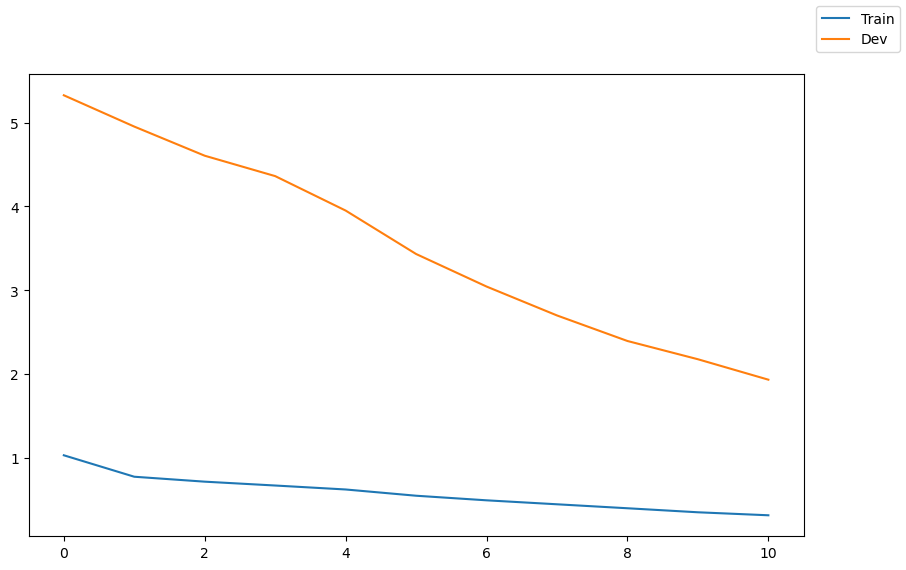

In [491]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train_loss, label='Train')
ax.plot(dev_loss, label='Dev')
fig.legend()
fig.savefig('math_loss_curves.png')